In [3]:
import numpy as np
import torch
import torch.nn as nn
from copy import deepcopy
import random
import os
import matplotlib.pyplot as plt

In [20]:
class ReplayBuffer:
    def __init__(self, capacity, device):
        self.capacity = int(capacity) # capacity of the buffer
        self.data = []
        self.index = 0 # index of the next cell to be filled
        self.device = device
    def append(self, s, a, r, s_, d):
        if len(self.data) < self.capacity:
            self.data.append(None)
        self.data[self.index] = (s, a, r, s_, d)
        self.index = (self.index + 1) % self.capacity
    def sample(self, batch_size):
        batch = random.sample(self.data, batch_size)
        return list(map(lambda x:torch.Tensor(np.array(x)).to(self.device), list(zip(*batch))))
    def __len__(self):
        return len(self.data)

In [21]:
def greedy_action(network, state):
    device = "cuda" if next(network.parameters()).is_cuda else "cpu"
    with torch.no_grad():
        Q = network(torch.Tensor(state).unsqueeze(0).to(device))
        return torch.argmax(Q).item()

In [25]:
class dqn_agent:
    def __init__(self, config, model):
        device = "cuda" if next(model.parameters()).is_cuda else "cpu"
        self.nb_actions = config['nb_actions']
        self.gamma = config['gamma'] if 'gamma' in config.keys() else 0.95
        self.batch_size = config['batch_size'] if 'batch_size' in config.keys() else 100
        buffer_size = config['buffer_size'] if 'buffer_size' in config.keys() else int(1e5)
        self.memory = ReplayBuffer(buffer_size,device)
        self.epsilon_max = config['epsilon_max'] if 'epsilon_max' in config.keys() else 1.
        self.epsilon_min = config['epsilon_min'] if 'epsilon_min' in config.keys() else 0.01
        self.epsilon_stop = config['epsilon_decay_period'] if 'epsilon_decay_period' in config.keys() else 1000
        self.epsilon_delay = config['epsilon_delay_decay'] if 'epsilon_delay_decay' in config.keys() else 20
        self.epsilon_step = (self.epsilon_max-self.epsilon_min)/self.epsilon_stop
        self.model = model 
        self.target_model = deepcopy(self.model).to(device)
        self.criterion = config['criterion'] if 'criterion' in config.keys() else torch.nn.MSELoss()
        lr = config['learning_rate'] if 'learning_rate' in config.keys() else 0.001
        self.optimizer = config['optimizer'] if 'optimizer' in config.keys() else torch.optim.Adam(self.model.parameters(), lr=lr)
        self.nb_gradient_steps = config['gradient_steps'] if 'gradient_steps' in config.keys() else 1
        self.update_target_strategy = config['update_target_strategy'] if 'update_target_strategy' in config.keys() else 'replace'
        self.update_target_freq = config['update_target_freq'] if 'update_target_freq' in config.keys() else 20
        self.update_target_tau = config['update_target_tau'] if 'update_target_tau' in config.keys() else 0.005
    
    def gradient_step(self):
        if len(self.memory) > self.batch_size:
            X, A, R, Y, D = self.memory.sample(self.batch_size)
            QYmax = self.target_model(Y).max(1)[0].detach()
            update = torch.addcmul(R, 1-D, QYmax, value=self.gamma)
            QXA = self.model(X).gather(1, A.to(torch.long).unsqueeze(1))
            loss = self.criterion(QXA, update.unsqueeze(1))
            self.optimizer.zero_grad()
            loss.backward()
            self.optimizer.step() 
    
    def train(self, env, max_episode):
        episode_return = []
        episode = 0
        episode_cum_reward = 0
        state, _ = env.reset()
        epsilon = self.epsilon_max
        step = 0
        while episode < max_episode:
            # update epsilon
            if step > self.epsilon_delay:
                epsilon = max(self.epsilon_min, epsilon-self.epsilon_step)
            # select epsilon-greedy action
            if np.random.rand() < epsilon:
                action = env.action_space.sample()
            else:
                action = greedy_action(self.model, state)
            # step
            next_state, reward, done, trunc, _ = env.step(action)
            self.memory.append(state, action, reward, next_state, done)
            episode_cum_reward += reward
            # train
            for _ in range(self.nb_gradient_steps): 
                self.gradient_step()
            # update target network if needed
            if self.update_target_strategy == 'replace':
                if step % self.update_target_freq == 0: 
                    self.target_model.load_state_dict(self.model.state_dict())
            if self.update_target_strategy == 'ema':
                target_state_dict = self.target_model.state_dict()
                model_state_dict = self.model.state_dict()
                tau = self.update_target_tau
                for key in model_state_dict:
                    target_state_dict[key] = tau*model_state_dict[key] + (1-tau)*target_state_dict[key]
                self.target_model.load_state_dict(target_state_dict)
            # next transition
            step += 1
            if done or trunc:
                episode += 1
                print("Episode ", '{:3d}'.format(episode), 
                      ", epsilon ", '{:6.2f}'.format(epsilon), 
                      ", batch size ", '{:5d}'.format(len(self.memory)), 
                      ", episode return ", '{:4.1f}'.format(episode_cum_reward),
                      sep='')
                state, _ = env.reset()
                episode_return.append(episode_cum_reward)
                episode_cum_reward = 0
            else:
                state = next_state
        return episode_return

In [26]:
from gymnasium.wrappers import TimeLimit
from env_hiv import HIVPatient

env = TimeLimit(
    env=HIVPatient(domain_randomization=False), max_episode_steps=200
)  # The time wrapper limits the number of steps in an episode at 200.
# Now is the floor is yours to implement the agent and train it.

cuda
Episode   1, epsilon   0.82, batch size   200, episode return 8550816.3
Episode   2, epsilon   0.62, batch size   400, episode return 10951780.6
Episode   3, epsilon   0.43, batch size   600, episode return 6637274.5
Episode   4, epsilon   0.23, batch size   800, episode return 5214215.4
Episode   5, epsilon   0.03, batch size  1000, episode return 10639026.1
Episode   6, epsilon   0.01, batch size  1200, episode return 11329660.8
Episode   7, epsilon   0.01, batch size  1400, episode return 11575135.5
Episode   8, epsilon   0.01, batch size  1600, episode return 10053680.4
Episode   9, epsilon   0.01, batch size  1800, episode return 8541319.3
Episode  10, epsilon   0.01, batch size  2000, episode return 6298707.2
Episode  11, epsilon   0.01, batch size  2200, episode return 6699716.4
Episode  12, epsilon   0.01, batch size  2400, episode return 10422069.2
Episode  13, epsilon   0.01, batch size  2600, episode return 7700206.8
Episode  14, epsilon   0.01, batch size  2800, episod

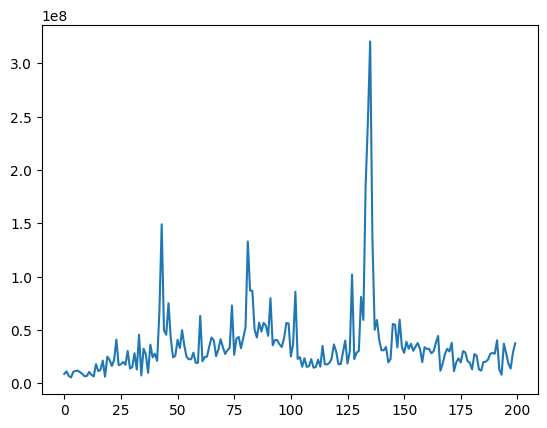

In [27]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

# Declare network
state_dim = env.observation_space.shape[0]
n_action = env.action_space.n 
nb_neurons=24
DQN = torch.nn.Sequential(nn.Linear(state_dim, nb_neurons),
                          nn.ReLU(),
                          nn.Linear(nb_neurons, nb_neurons),
                          nn.ReLU(), 
                          nn.Linear(nb_neurons, n_action)).to(device)

# DQN config
config = {'nb_actions': env.action_space.n,
          'learning_rate': 0.001,
          'gamma': 0.99,
          'buffer_size': 1000000,
          'epsilon_min': 0.01,
          'epsilon_max': 1.,
          'epsilon_decay_period': 1000,
          'epsilon_delay_decay': 20,
          'batch_size': 512,
          'gradient_steps': 1,
          'update_target_strategy': 'ema', # or 'ema'
          'update_target_freq': 50,
          'update_target_tau': 0.005,
          'criterion': torch.nn.SmoothL1Loss()}

# Train agent
agent = dqn_agent(config, DQN)
scores = agent.train(env, 200)
plt.plot(scores)

In [14]:
torch.save(DQN, os.path.join(os.getcwd(), "models/DQN3.pt"))